In [1]:
import pandas as pd
import glob
import re
from sklearn.preprocessing import LabelEncoder
import numpy as np

csv_files = glob.glob("*.csv")

df_accident = pd.read_csv('accident.csv')
df_vehicle = pd.read_csv('vehicle.csv')
df_person = pd.read_csv('person.csv')
keep_column_accident = ['ACCIDENT_NO', 'ACCIDENT_DATE', 'ACCIDENT_TIME',
    'ACCIDENT_TYPE', 'ACCIDENT_TYPE_DESC', 'DAY_OF_WEEK',
    'LIGHT_CONDITION', 'NO_OF_VEHICLES',
    'NO_PERSONS_KILLED', 'NO_PERSONS_INJ_2', 'NO_PERSONS_INJ_3',
    'NO_PERSONS_NOT_INJ', 'NO_PERSONS',
    'POLICE_ATTEND', 'ROAD_GEOMETRY',
    'SEVERITY', 'SPEED_ZONE']
df_accident = df_accident[keep_column_accident]

#create a column that displays only the year of the accident happened
df_accident['acc_year'] = df_accident['ACCIDENT_DATE'].str.extract(r'(\d{4})').astype(int)


keep_column_vehicle = [
    'ACCIDENT_NO', 'VEHICLE_ID', 'VEHICLE_YEAR_MANUF',
    'ROAD_SURFACE_TYPE', 'ROAD_SURFACE_TYPE_DESC', 'VEHICLE_MAKE',
    'VEHICLE_TYPE', 'VEHICLE_TYPE_DESC', 'LEVEL_OF_DAMAGE',
    'INITIAL_IMPACT', 'DRIVER_INTENT', 'VEHICLE_MOVEMENT',
    'CAUGHT_FIRE', 'TOTAL_NO_OCCUPANTS'
]
df_vehicle = df_vehicle[keep_column_vehicle]


keep_column_person = [
    'ACCIDENT_NO', 'PERSON_ID', 'VEHICLE_ID',
    'SEX', 'AGE_GROUP', 'INJ_LEVEL',
    'SEATING_POSITION', 'HELMET_BELT_WORN',
    'ROAD_USER_TYPE','ROAD_USER_TYPE_DESC', 'TAKEN_HOSPITAL', 'EJECTED_CODE'
]
df_person = df_person[keep_column_person]
#replace all the other sex data except M or F to the mode of sex
mode_sex = df_person['SEX'].mode()[0]
df_person['SEX'] = df_person['SEX'].apply(lambda x: x if x in ['M', 'F'] else mode_sex)
#transform all the age_group to the normalized format, extreme example like 5-MAY will transform to Unknown
#the age group like 70+ will be kept
valid_age_group_regex = r'^\d{1,2}-\d{1,2}$|^\d{2}\+$'
df_person['AGE_GROUP'] = df_person['AGE_GROUP'].where(df_person['AGE_GROUP'].str.match(valid_age_group_regex), 'Unknown')
def categorize_age(age_group):
    if re.match(r'^\d{2}\+$', age_group):
        base_age = int(age_group[:-1])
        if base_age >= 70:
            return '70+'
    elif re.match(r'^\d{1,2}-\d{1,2}$', age_group):
        start_age, end_age = map(int, age_group.split('-'))
        if start_age < 18:
            return '0-17'
        elif 18 <= start_age <= 29:
            return '18-29'
        elif 30 <= start_age <= 39:
            return '30-39'
        elif 40 <= start_age <= 49:
            return '40-49'
        elif 50 <= start_age <= 59:
            return '50-59'
        elif 60 <= start_age <= 69:
            return '60-69'
        elif start_age >= 70:
            return '70+'
    return 'Unknown'

df_person['AGE_GROUP'] = df_person['AGE_GROUP'].apply(categorize_age)
#replace unknown data to the mode of 'AGE_GROUP'
moded_age_group = df_person['AGE_GROUP'].mode()[0]
df_person['AGE_GROUP'] = df_person['AGE_GROUP'].replace('Unknown', moded_age_group)
#fill the unknown helmet worn data with mode data
mode_helmet = df_person['HELMET_BELT_WORN'].mode()[0]
df_person['HELMET_BELT_WORN'] = df_person['HELMET_BELT_WORN'].fillna(mode_helmet)
#reduce the group of road_users
road_usertype_map = {
    'Drivers': 'Driver',
    'Motorcyclists': 'Driver',
    'Pillion Passengers': 'Passenger',
    'Passengers': 'Passenger',
    'Pedestrians': 'Pedestrian',
    'Bicyclists': 'Cyclist',
    'E-scooter Rider': 'Cyclist',
    'Not Known': 'Unknown'
}
df_person['ROAD_USER_TYPE_DESC'] = df_person['ROAD_USER_TYPE_DESC'].map(road_usertype_map)
#re define the road_user_type
le = LabelEncoder()
df_person['ROAD_USER_TYPE'] = le.fit_transform(df_person['ROAD_USER_TYPE_DESC'])

fill_map = (
    df_person[df_person['TAKEN_HOSPITAL'] != 'nah']
    .groupby('INJ_LEVEL')['TAKEN_HOSPITAL']
    .agg(lambda x: x.mode()[0])
    .to_dict()
)

df_person['TAKEN_HOSPITAL'] = df_person['TAKEN_HOSPITAL'].replace('', 'N')

# for vehicle data cleaning
# replace all the 0s with missing values
df_vehicle['VEHICLE_YEAR_MANUF'] = df_vehicle['VEHICLE_YEAR_MANUF'].replace(0, np.nan)

# fill rows having missing values with the mode of the given columns

v_modes = df_vehicle.mode().iloc[0]


# we want to calculate the age of vehicles later so we cannot fill na with mode for year of made
cols_to_fill = df_vehicle.columns.difference(['VEHICLE_YEAR_MANUF'])
df_vehicle[cols_to_fill] = df_vehicle[cols_to_fill].fillna(v_modes)


acc_veh = pd.merge(df_accident, df_vehicle, on='ACCIDENT_NO', how='left')

# now get the age of the vehicle
acc_veh['AGE'] = acc_veh['acc_year'] - acc_veh['VEHICLE_YEAR_MANUF']
mean_age = acc_veh['AGE'].mean()
# fill the missing values in age with mean_age because we will make two groups later
# and we don't want one group is way more than the other, and the threshold can have decimal places
acc_veh['AGE'] = acc_veh['AGE'].fillna(mean_age)

def categorize_vehicle_age(age):
    if age < 5:
        return '0-4 years'
    elif 5 <= age < 10:
        return '5-9 years'
    elif 10 <= age < 15:
        return '10-14 years'
    else:
        return '15+ years'

acc_veh['VEHICLE_AGE_GROUP'] = acc_veh['AGE'].apply(categorize_vehicle_age)

def categorize_speed_zone(speed):
    if speed < 60:
        return 'low speed'
    elif 60 <= speed < 80:
        return 'medium speed'
    else:
        return 'high speed'

acc_veh['SPEED_ZONE_GROUP'] = acc_veh['SPEED_ZONE'].apply(categorize_speed_zone)

light_condition_map = {
    1: 'daytime',
    2: 'nighttime（light on）',
    3: 'nighttime（no light）',
    4: 'dusk',
    5: 'unknown'
}
acc_veh['LIGHT_CONDITION_DESC'] = acc_veh['LIGHT_CONDITION'].map(light_condition_map)

merged_df = pd.merge(acc_veh, df_person, on='ACCIDENT_NO', how='left')
merged_df['acc_veh'] = merged_df['AGE'].apply(
    lambda age: 'Old' if age > 10 else ('New' if pd.notnull(age) else np.nan)
    )

keep_column_acc_veh = [
    'ACCIDENT_NO', 'SEVERITY', 'SPEED_ZONE','SPEED_ZONE_GROUP' ,'LIGHT_CONDITION','LIGHT_CONDITION_DESC',
    'ACCIDENT_DATE', 'VEHICLE_ID_x', 'VEHICLE_YEAR_MANUF',
    'VEHICLE_AGE_GROUP', 'ROAD_USER_TYPE_DESC'
]

merged_df = merged_df[keep_column_acc_veh]
merged_df.head()

,ACCIDENT_NO,SEVERITY,SPEED_ZONE,SPEED_ZONE_GROUP,LIGHT_CONDITION,LIGHT_CONDITION_DESC,ACCIDENT_DATE,VEHICLE_ID_x,VEHICLE_YEAR_MANUF,VEHICLE_AGE_GROUP,ROAD_USER_TYPE_DESC
0,T20120000046,3,60,medium speed,1,daytime,2012-01-01,A,2001.0,10-14 years,Pedestrian
1,T20120000046,3,60,medium speed,1,daytime,2012-01-01,A,2001.0,10-14 years,Driver
2,T20120000062,2,100,high speed,1,daytime,2012-01-01,A,2010.0,0-4 years,Driver
3,T20120000060,2,60,medium speed,1,daytime,2012-01-01,A,2008.0,0-4 years,Driver
4,T20120000009,3,100,high speed,5,unknown,2012-01-01,A,1996.0,15+ years,Passenger


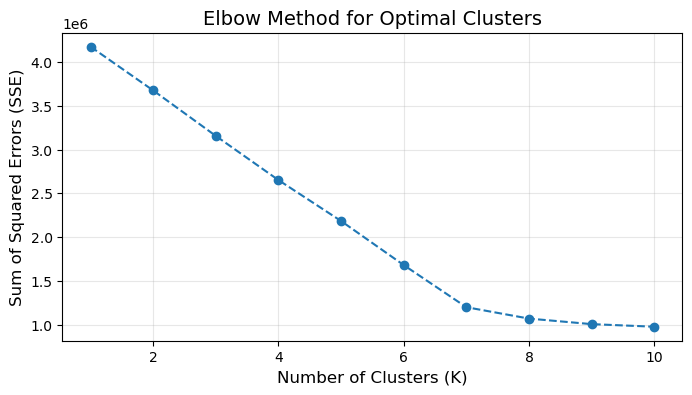

In [2]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

driver_data = df_person[['AGE_GROUP', 'SEX', 'ROAD_USER_TYPE_DESC', 'INJ_LEVEL']].copy()
driver_data.dropna(inplace=True)  # 删除缺失值

le = LabelEncoder()
driver_data['SEX_encoded'] = le.fit_transform(driver_data['SEX'])
driver_data['ROAD_USER_encoded'] = le.fit_transform(driver_data['ROAD_USER_TYPE_DESC'])
driver_data['INJ_LEVEL_encoded'] = le.fit_transform(driver_data['INJ_LEVEL'])

age_onehot = pd.get_dummies(driver_data['AGE_GROUP'], prefix='age')
X = pd.concat([
    driver_data[['SEX_encoded', 'ROAD_USER_encoded', 'INJ_LEVEL_encoded']],
    age_onehot
], axis=1)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    sse.append(kmeans.inertia_)

plt.figure(figsize=(8, 4))
plt.plot(range(1, 11), sse, marker='o', linestyle='--', color='#1f77b4')
plt.xlabel('Number of Clusters (K)', fontsize=12)
plt.ylabel('Sum of Squared Errors (SSE)', fontsize=12)
plt.title('Elbow Method for Optimal Clusters', fontsize=14)
plt.grid(alpha=0.3)
plt.show()

kmeans = KMeans(n_clusters=3, random_state=42)
driver_data['Cluster'] = kmeans.fit_predict(X_scaled)

C:\Users\31236\AppData\Roaming\Python\Python312\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


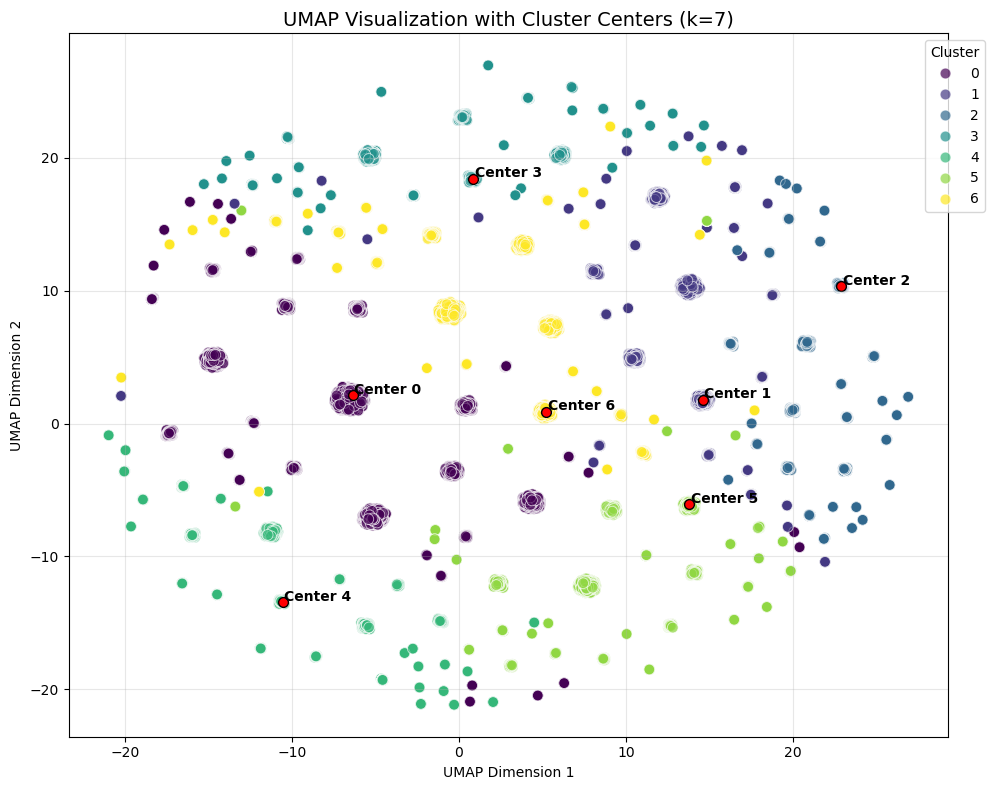

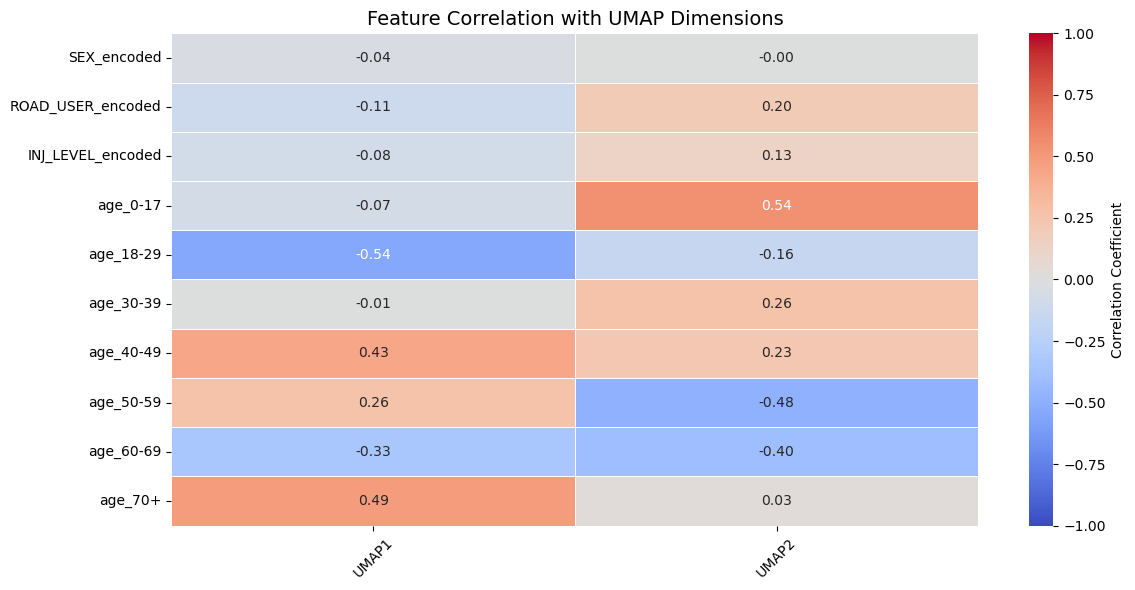

In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.cluster import KMeans
import umap as umap  # PCA->UMAP
import matplotlib.pyplot as plt
import seaborn as sns


driver_data = df_person[['AGE_GROUP', 'SEX', 'ROAD_USER_TYPE_DESC', 'INJ_LEVEL']].copy()
driver_data.dropna(inplace=True)

le = LabelEncoder()
driver_data['SEX_encoded'] = le.fit_transform(driver_data['SEX'])
driver_data['ROAD_USER_encoded'] = le.fit_transform(driver_data['ROAD_USER_TYPE_DESC'])
driver_data['INJ_LEVEL_encoded'] = le.fit_transform(driver_data['INJ_LEVEL'])

age_onehot = pd.get_dummies(driver_data['AGE_GROUP'], prefix='age')
X = pd.concat([
    driver_data[['SEX_encoded', 'ROAD_USER_encoded', 'INJ_LEVEL_encoded']],
    age_onehot
], axis=1)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

kmeans = KMeans(n_clusters=7, random_state=42, n_init=20)
driver_data['Cluster'] = kmeans.fit_predict(X_scaled)

reducer = umap.UMAP(n_components=2, random_state=42, n_neighbors=15, min_dist=0.1)
X_umap = reducer.fit_transform(X_scaled)

centers_umap = reducer.transform(kmeans.cluster_centers_)

plt.figure(figsize=(10, 8))
scatter = sns.scatterplot(data=pd.DataFrame(X_umap, columns=['UMAP1', 'UMAP2']), 
                         x='UMAP1', y='UMAP2', 
                         hue=driver_data['Cluster'],
                         palette='viridis', 
                         s=60, alpha=0.7)

for i, center in enumerate(centers_umap):
    scatter.scatter(center[0], center[1], marker='.', s=200, 
                   c='red', edgecolor='black', linewidth=1)
    scatter.text(center[0]+0.1, center[1]+0.1, f'Center {i}', 
                fontsize=10, weight='bold')

plt.title('UMAP Visualization with Cluster Centers (k=7)', fontsize=14)
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1))
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

feature_names = list(driver_data[['SEX_encoded', 'ROAD_USER_encoded', 'INJ_LEVEL_encoded']].columns) + list(age_onehot.columns)

result_df = pd.DataFrame(X_umap, columns=['UMAP1', 'UMAP2'])
feature_df = pd.DataFrame(X_scaled, columns=feature_names)  # 标准化后的原始特征

corr_matrix = pd.concat([feature_df, result_df], axis=1).corr().loc[feature_names, ['UMAP1', 'UMAP2']]

plt.figure(figsize=(12, 6))
sns.heatmap(corr_matrix, 
            cmap='coolwarm', 
            annot=True, 
            fmt=".2f",
            center=0,
            vmin=-1, vmax=1,
            linewidths=0.5,
            cbar_kws={'label': 'Correlation Coefficient'})

plt.title("Feature Correlation with UMAP Dimensions", fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()